In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def plotter(history):
  plt.figure()
  plt.plot(history.history['loss'],label='train loss')
  plt.plot(history.history['val_loss'],label='test loss')
  plt.xlabel('iterations')
  plt.ylabel('losses')
  plt.legend()
  plt.figure()
  plt.plot(history.history['accuracy'],label='train accuracy')
  plt.plot(history.history['val_accuracy'],label='test accuracy')
  plt.xlabel('iterations')
  plt.ylabel('accuracy')
  plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Emotion-Recognition-from-Speech/dataset.csv')
Features.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_156,Feature_157,Feature_158,Feature_159,Feature_160,Feature_161,Feature_162,Feature_163,Feature_164,label
0,0.266808,-509.529572,24.022825,-14.907886,-0.697563,-11.522958,-9.965440,-11.921485,-13.617157,-3.646201,...,0.001355,0.000793,0.000972,0.001552,0.001190,1.153455e-04,3415.965681,6199.068541,0.536707,fearful+normal+female
1,0.413118,-730.670471,38.349815,2.674319,9.384073,-5.979620,-3.029608,-11.018359,-9.151864,-7.464394,...,0.000024,0.000019,0.000015,0.000011,0.000005,4.307079e-07,3595.106464,6334.114193,0.499593,calm+normal+female
2,0.345513,-683.846619,41.367165,-2.767712,1.023483,-4.020317,-7.462221,-11.155664,-7.080593,-11.429027,...,0.000044,0.000041,0.000028,0.000022,0.000016,1.913279e-06,3434.880446,6269.021037,0.470204,calm+strong+female
3,0.277406,-578.768799,50.480259,-11.826157,3.023091,-10.381796,-13.910265,-5.369832,-13.442755,-10.330565,...,0.000273,0.000396,0.000903,0.001079,0.000450,4.981600e-05,2765.004332,5179.336532,0.582388,sad+strong+female
4,0.308712,-708.799866,48.700954,1.122221,0.025111,-7.621972,-7.224838,-12.110167,-8.403195,-12.154092,...,0.000056,0.000051,0.000021,0.000025,0.000012,7.320705e-07,3130.792541,5595.043945,0.468202,calm+strong+female


In [ ]:
from sklearn.utils import shuffle
temp = shuffle(Features)

df = np.random.rand(len(temp)) < 0.8
train = temp[df]
test = temp[~df]

In [ ]:
trainFeatures = train.iloc[:, :-1]
trainLabel = train.iloc[:, -1]
testFeatures = test.iloc[:, :-1]
testLabel = test.iloc[:, -1]

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainFeatures)
y_train = np.array(trainLabel)
X_test = np.array(testFeatures)
y_test = np.array(testLabel)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train), num_classes=30)
y_test = to_categorical(lb.fit_transform(y_test), num_classes=30)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Input, LSTM, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import tensorflow as tf

# Define a simple attention layer
class AttentionLayer(Layer):
    def __init__(self, return_sequences=False):
        super(AttentionLayer, self).__init__()
        self.return_sequences = return_sequences

    def call(self, inputs):
        # Attention mechanism
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)

        if self.return_sequences:
            return context_vector
        else:
            return tf.reduce_sum(context_vector, axis=1)

# Create the CNN-LSTM-Attention model
inputs = Input(shape=(164, 1))  # Input shape

# CNN layers
x = Conv1D(16, kernel_size=2, strides=1, padding='valid', kernel_initializer='normal')(inputs)
x = MaxPooling1D(pool_size=2, strides=1)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Conv1D(32, kernel_size=2, strides=1, padding='valid', kernel_initializer='normal')(x)
x = MaxPooling1D(pool_size=2, strides=1)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Conv1D(64, kernel_size=2, strides=1, padding='valid', kernel_initializer='normal')(x)
x = MaxPooling1D(pool_size=2, strides=1)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Conv1D(128, kernel_size=2, strides=1, padding='valid', kernel_initializer='normal')(x)
x = MaxPooling1D(pool_size=2, strides=1)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# Here we need to adjust the input for LSTM
# We can reshape to (batch_size, time_steps, features)
# The output of the last Conv1D should be reshaped correctly

x = BatchNormalization(axis=-1)(x)

# LSTM layer
x = LSTM(256, return_sequences=True)(x)
x = Activation('tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Attention layer
x = AttentionLayer(return_sequences=False)(x)

# Fully connected layer
x = Dense(100)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Output layer for multi-class classification
output = Dense(30, name='output_layer')(x)  # 30 classes
output = Activation('softmax')(output)  # Use softmax for multi-class classification

# Create model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 164, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 163, 16)             │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 162, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 162, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 162, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 162, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 161, 32)             │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 160, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 160, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 160, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 160, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 159, 64)             │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 158, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 158, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 158, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 158, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 157, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 156, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 156, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 447,242 (1.71 MB)

 Trainable params: 445,994 (1.70 MB)

 Non-trainable params: 1,248 (4.88 KB)

In [22]:
history = model.fit(X_train, y_train, batch_size=256, epochs=10000, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.0374 - loss: 3.4012 - val_accuracy: 0.0268 - val_loss: 3.4079
Epoch 2/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.0313 - loss: 3.4001 - val_accuracy: 0.0268 - val_loss: 3.4079
Epoch 3/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.0367 - loss: 3.4001 - val_accuracy: 0.0268 - val_loss: 3.4079
Epoch 4/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.0357 - loss: 3.3998 - val_accuracy: 0.0268 - val_loss: 3.4079
Epoch 5/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.0364 - loss: 3.4005 - val_accuracy: 0.0268 - val_loss: 3.4079
Epoch 6/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.0347 - loss: 3.3991 - val_accuracy: 0.0268 - val_loss: 3.4079
Epoch 7/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.0275 - loss: 3.4010 - val_accuracy: 0.0268 - val_loss: 3.4079
Epoch 8/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.0338 - loss: 3.4004 - val_accuracy: 0.

KeyboardInterrupt: 

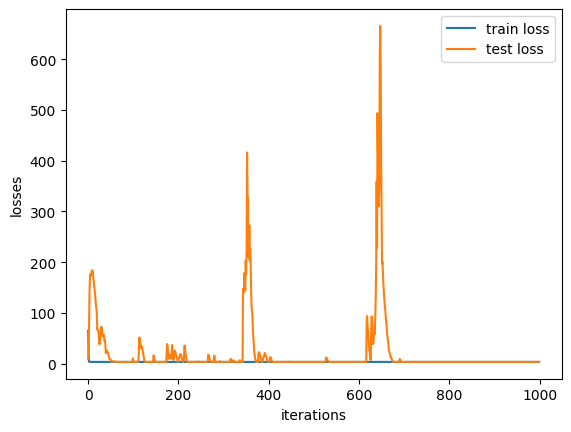

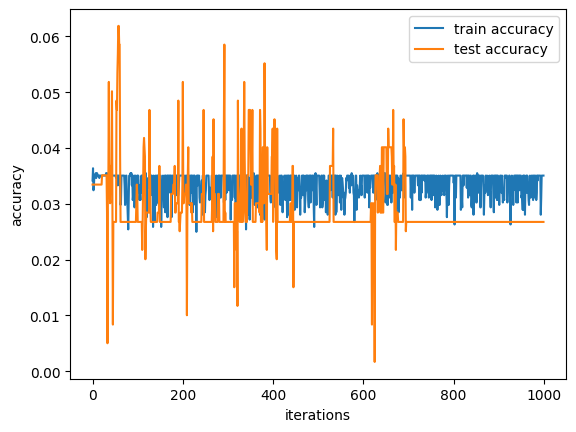

In [11]:
plotter(history)

In [24]:
# Input layer
inputs = Input(shape=(X_train.shape[1], 1))

x = Conv1D(64, kernel_size=(10), activation='relu')(inputs)
x = Conv1D(128, kernel_size=(10), activation='relu')(x)
x = MaxPooling1D(pool_size=(8))(x)
x = Dropout(0.4)(x)

x = Conv1D(128, kernel_size=(10), activation='relu')(x)
x = MaxPooling1D(pool_size=(8))(x)
x = Dropout(0.4)(x)

x = Conv1D(64, 5, padding='same')(x)
x = Activation('relu')(x)

x = np.expand_dims(x, axis=1)

x = LSTM(128)(x)
x = Dropout(0.2)(x)

x = LSTM(64)(x)
x = Dropout(0.2)(x)

x = Dense(32)(x)

# Output layer for multi-class classification
output = Dense(30, name='output_layer')(x)  # 30 classes
output = Activation('softmax')(output)  # Use softmax for multi-class classification

# Create model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 164, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 155, 64)             │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 146, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 18, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 18, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 9, 128)              │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 1, 64)               │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 30)                  │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 30)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289,694 (1.11 MB)

 Trainable params: 289,694 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train, y_train, batch_size=256, epochs=1000, validation_data=(X_test, y_test))

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 590ms/step - accuracy: 0.0519 - loss: 3.6169 - val_accuracy: 0.0552 - val_loss: 3.2655
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0618 - loss: 3.2761 - val_accuracy: 0.1137 - val_loss: 3.1706
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0818 - loss: 3.1873 - val_accuracy: 0.1187 - val_loss: 3.0943
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1000 - loss: 3.1259 - val_accuracy: 0.1388 - val_loss: 3.0084
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1177 - loss: 3.0327 - val_accuracy: 0.1405 - val_loss: 2.8498
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1261 - loss: 2.9352 - val_accuracy: 0.1371 - val_loss: 2.7367
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1599 - loss: 2.7988 - val_accuracy: 0.1538 - val_loss: 2.6267
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1702 - loss: 2.6792 - val_accuracy: 0.1823 -

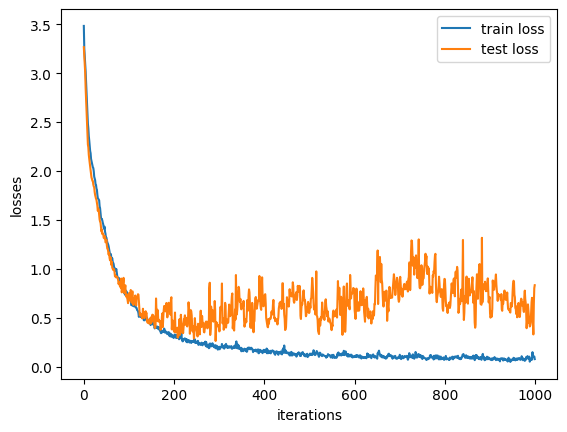

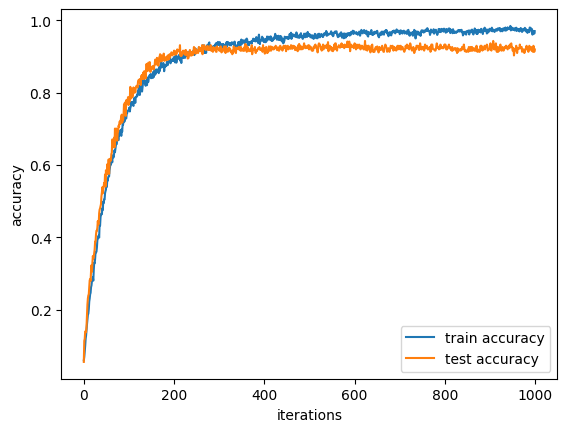

In [26]:
plotter(history)